In [1]:
from cuda_layers import *
import numpy as np
import matplotlib.pyplot as plt
import torch
if torch.cuda.is_available() == True:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

Label = 5


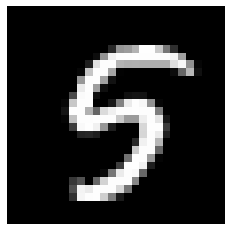

In [10]:
import pandas as pd
import os

def visualize_image(index=6):
    train_pd = pd.read_csv(os.path.join('digits', 'train.csv'))
    train_np = train_pd.to_numpy()
    train_X = train_np.T[1:].T
    train_y = train_np.T[0].T
    plt.imshow(train_X[index].reshape(28,28), cmap='gray')
    plt.axis('off')
    print(f'Label = {train_y[index]}')
    return train_X, train_y

class MNISTDataset:
    def __init__(self, X, y=None):
        self.X =X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


def data_preparation(train_X, train_y, denominator=5):
    split = len(train_X)//denominator
    train_data = MNISTDataset(train_X[:-split], y=train_y[:-split])
                        
    test_data = MNISTDataset(train_X[-split:], y=train_y[-split:])
    return train_data, test_data


data_X, data_y = visualize_image(8)

train_data, test_data = data_preparation(data_X, data_y)

iter_num = 1
pics = [0,1,3,6,7,8,10,11,16,21]

In [24]:
torch.random.manual_seed(42)
pics = [0,1]
pics = [0,1,3,6,7,8,10,11,16,21]
#pics = [1,8]
in_layer = Input_layer(device=device, size=28*28, g=.01, assymetry=2.05, learning_rate=.01, resolution=.1)
out_layer = Output_layer(device=device, size=len(pics), resolution=.1)
in_layer.make_connections(out_layer)
for epoch in range(3):
    for i in range(len(pics)):
        #print(train_data[i][0])
        signal = torch.tensor(train_data[pics[i]][0]) * 0.06
        #print(signal.max(), signal.min())
        signal.to(device)
        #signal = (signal - signal.min()) / (signal.max() - signal.min())
        for time in range(int(70//.1)):
            in_layer.apply_current(signal=signal)
            #_ = in_layer.behave()
            in_layer.transmit_current()
            out_layer.I[train_data[pics[i]][1]] += 11
            _ = out_layer.behave()
            out_layer.drop_impulse()
            in_layer.normalize_weights()
        in_layer.reboot_variables()
        out_layer.reboot_variables()
    print(f'epoch {epoch} passed')

c:\Users\KG\Desktop\Projects\snn_with_cuda\snn_with_cuda\cuda_layers.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sig = torch.tensor(signal)


epoch 0 passed
epoch 1 passed
epoch 2 passed


pic 0 checked
tensor(0.)
pic 1 checked
tensor(0.)
pic 2 checked
tensor(0.7440)
pic 3 checked
tensor(0.3543)
pic 4 checked
tensor(0.)
pic 5 checked
tensor(1.0948)
pic 6 checked
tensor(5.7815)
pic 7 checked
tensor(0.)
pic 8 checked
tensor(3.0533)
pic 9 checked
tensor(1.0849)
preds [6 6 6 6 6 6 6 6 6 6]
gts [1 0 4 7 3 5 8 9 2 6]
accuracy 0.1


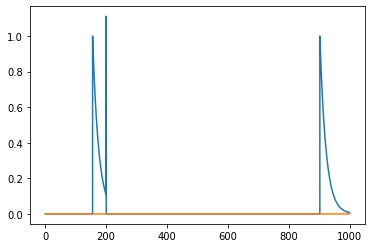

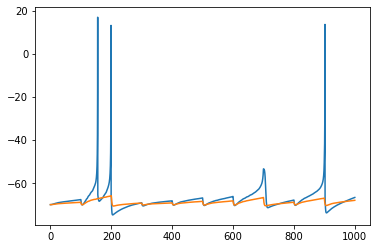

In [25]:
imp0 = []
imp1 = []
volt0 = []
volt1 = []

preds = []
gts = []
in_layer.update_weights = False
for i in range(len(pics)):
    curs = torch.zeros(len(pics))
    curs.to(device)
    signal = torch.tensor(train_data[pics[i]][0]) * 0.06
    signal.to(device)
    #signal = (signal - signal.min()) / (signal.max() - signal.min())
    for time in range(int(100//.1) + 1):
        in_layer.apply_current(signal=signal)
        #_ = in_layer.behave()
        in_layer.transmit_current()
        _ = out_layer.behave()
        curs += out_layer.I
        imp0.append(out_layer.impulse[0].item())
        imp1.append(out_layer.impulse[1].item())
        volt0.append(out_layer.v[0].item())
        volt1.append(out_layer.v[1].item())
    preds.append(torch.argmax(curs).item())
    gts.append(train_data[pics[i]][1])
    print(f'pic {i} checked')
    print(out_layer.impulse[i])
    in_layer.reboot_variables()
    out_layer.reboot_variables()
preds = np.array(preds)
gts = np.array(gts)
correct = np.sum(preds == gts)
accuracy = correct / len(pics)
print(f'preds {preds}')
print(f'gts {gts}')
print(f'accuracy {accuracy}')

x = np.arange(len(imp0)) * .1
plt.figure()
plt.plot(x, imp0)
plt.plot(x, imp1)
plt.figure()
plt.plot(x, volt0)
plt.plot(x, volt1)
plt.show()

c:\Users\KG\Desktop\Projects\snn_with_cuda\snn_with_cuda\cuda_layers.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sig = torch.tensor(signal)


tensor(0.9013)
tensor(0.0010)


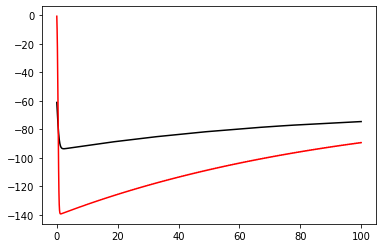

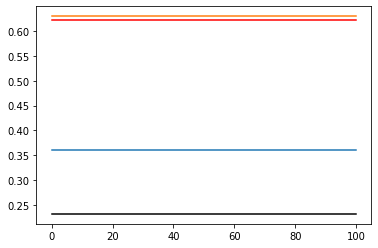

In [17]:
torch.random.manual_seed(42)
inimp0 = []
inimp1 = []
outimp0 = []
outimp1 = []
w00 = []
w01 = []
w10 = []
w11 = []
for i in range(int(1000)+1):
    in_layer.apply_current(signal=signal)
    #_ = in_layer.behave()
    in_layer.transmit_current()
    out_layer.I[0] += 0
    out_layer.I[1] += 0
    _ = out_layer.behave()
    inimp0.append(in_layer.impulse[0].item())
    inimp1.append(in_layer.impulse[1].item())
    outimp0.append(out_layer.v[0].item())
    outimp1.append(out_layer.v[1].item())
    w00.append(in_layer.weights[0,0].item())
    w01.append(in_layer.weights[0,1].item())
    w10.append(in_layer.weights[1,0].item())
    w11.append(in_layer.weights[1,1].item())
    out_layer.drop_impulse()
    #print(f'iter {i} passed')
print(in_layer.weights.max())
print(in_layer.weights.min())
x = np.arange(len(inimp0)) * .1
x1 = np.arange(len(imp0)) * .1
plt.figure()
#plt.plot(x, inimp0)
#plt.plot(x, inimp1)
plt.plot(x, outimp0, color='black')
plt.plot(x, outimp1, color='red')
plt.figure()
plt.plot(x, w00)
plt.plot(x, w01)
plt.plot(x, w10, color='black')
plt.plot(x, w11, color='red')
plt.show()

In [ ]:
torch.random.manual_seed(42)
in_layer = Input_layer(device=device, size=100, g=10, assymetry=2.05, learning_rate=.001)
out_layer = Output_layer(device=device, size=1)
in_layer.make_connections(out_layer)
signal = np.ones(len(in_layer))
in_layer.apply_current(signal=signal)
inimp = []
outimp = []
ws = []
for i in range(int(100//.1) + 1):
    _ = in_layer.behave()
    in_layer.transmit_current()
    out_layer.I[0] += 11
    _ = out_layer.behave()
    inimp.append(in_layer.impulse[0].item())
    outimp.append(out_layer.impulse[0].item())
    ws.append(in_layer.weights[0,0].item())
    out_layer.drop_impulse()
in_layer.reboot_variables()
out_layer.reboot_variables()
in_layer.apply_current(signal=signal*10)

for i in range(int(100//.1) + 1):
    _ = in_layer.behave()
    in_layer.transmit_current()
    out_layer.I[0] += 11
    _ = out_layer.behave()
    inimp.append(in_layer.impulse[0].item())
    outimp.append(out_layer.impulse[0].item())
    ws.append(in_layer.weights[1,0].item())
    out_layer.drop_impulse()
    
x = np.arange(len(inimp)) * .1
plt.figure(figsize=(19.2,7.2))
plt.plot(x, inimp)
plt.plot(x, outimp)
plt.figure(figsize=(19.2,7.2))
plt.plot(x, ws)
plt.show()

In [ ]:
torch.random.manual_seed(42)
print(torch.rand(1))
in_layer = Input_layer(device=device, size=2)
in_layer.apply_current(signal=[5,10])
a0 = []
a1 = []
for i in range(1000):
    _ = in_layer.behave()
    b0 = in_layer.impulse[0].item()
    b1 = in_layer.impulse[1].item()
    a0.append(b0)
    a1.append(b1)
plt.plot(range(1000), a0)
plt.plot(range(1000), a1)
plt.show()

In [ ]:
torch.random.manual_seed(42)
in_layer = Input_layer(device=device, size=2, g=120)
out_layer = Output_layer(device=device, size=2)
in_layer.make_connections(out_layer)
in_layer.apply_current(signal=[7,10])

in0 = []
in1 = []
out0 = []
out1 = []
time = range(1000)
for i in range(1000):
    _ = in_layer.behave()
    in_layer.transmit_current()
    out_layer.I[0] += 6
    out_layer.I[1] += 9
    _ = out_layer.behave()
    a0 = in_layer.v[0].item()
    a1 = in_layer.v[1].item()
    b0 = out_layer.v[0].item()
    b1 = out_layer.v[1].item()
    out_layer.drop_impulse()
    in0.append(a0)
    in1.append(a1)
    out0.append(b0)
    out1.append(b1)

plt.plot(range(1000), in0)
plt.plot(range(1000), in1)
plt.show()
plt.plot(range(1000), out0)
plt.plot(range(1000), out1)
plt.show()

